# Preprocessing

In [1563]:
# Please email macw@cmu.edu to gain access to the Pitt corpus from DementiaBank

In [1564]:
import pandas as pd
import zipfile
import io

import re
import numpy as np\

from collections import Counter
from scipy.stats import ttest_ind
from scipy.stats import pearsonr
from scipy.stats import shapiro
from scipy import stats
from researchpy import ttest as rp
import matplotlib.pyplot as plt
import seaborn as sns

In [1565]:
data = []

zip_filename = 'Pitt.zip'
with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
    cha_files = [file for file in zip_ref.namelist() if file.endswith('.cha')]

    for file_name in cha_files:
        with zip_ref.open(file_name) as file:
            lines = io.TextIOWrapper(file, 'utf-8', newline='', line_buffering=True).readlines()

        participant_id = None
        transcript = []
        patient_data = None

        for line in lines:
            if line.startswith('@ID:') and 'PAR' in line: 
                if participant_id and transcript:
                    data.append({'Participant ID': participant_id, 'Transcript': ' '.join(transcript), 'Patient Data': patient_data, 'File Name': file_name})
                    transcript = []
                participant_id = line.strip().split()[-1]
                patient_data = line.strip() 
            elif line.startswith('*'):
                transcript.append(line.strip())

        if participant_id and transcript:
            data.append({'File Name': file_name,'Patient Demographic': patient_data, 'Transcript': ' '.join(transcript)})


pd.set_option('display.max_colwidth', None)
df = pd.DataFrame(data)

def process_transcript(text):
    return re.sub(r'(\w+)\s*:\[(\w+)]', r'[\2]', text)
df.head(126)

,File Name,Patient Demographic,Transcript
0,Pitt/Dementia/cookie/711-0.cha,@ID:\teng|Pitt|PAR|77;|male|PossibleAD||Participant|25||,*INV:\tI want you to take a look at this picture here and tell me *PAR:\toh ‡ you want me to tell you . [+ exc] 6440_7440 *INV:\t+< yeah ‡ just tell me everything that you see going on in that *PAR:\tthe mother and her two children . [+ gram] 10776_12656 *PAR:\tand the children are getting in the cookie jar . 12738_15758 *PAR:\tand she's doing the dishes and spilling the water . 15777_18357 *PAR:\tand she had the spigot on . 18380_19540 *PAR:\tand she didn't know it perhaps . 19555_21015 *PAR:\t&=coughs pardon me . [+ exc] 23468_23948 *PAR:\tand they're looking out into the garden from the kitchen window . 25452_28682 *PAR:\tit's open . 28700_29390 *PAR:\tand the &-uh cookies must be pretty good they're eating . 29407_34157 *PAR:\t<the tair [: chair] [* p:w-ret]> [//] &-uh the chair [: stool] *PAR:\tand &-uh <the lady> [//] the mother's splashing her shoes and *PAR:\tand there's &-um &-uh a window and curtains on the window . 47868_53838 *PAR:\tand I can see some trees outside there . 53855_56105 *PAR:\tand [/] and there's dishes that &+h had been washed . 57755_58335 *PAR:\tand she's dryin(g) them . 58335_61585 *PAR:\tand there's some shrub out there and +... 62110_63300 *INV:\tokay very good . 65087_67258
1,Pitt/Dementia/cookie/007-3.cha,@ID:\teng|Pitt|PAR|75;|female|ProbableAD||Participant|15||,*INV:\ton in the picture . 610_1310 *PAR:\twell the girl is telling the boy to get the cookies down but don't *PAR:\tand the boy is also falling over off the stool . 9667_13427 *PAR:\tand the mother is letting the water run out_of the sink . 14362_17802 *PAR:\tand she's dryin(g) dishes . 18708_20048 *PAR:\tI don't quite get that but then &=laughs +... [+ exc] 20100_23060 *PAR:\t&-uh she has water on the floor and [/] and basically it's kind_of *PAR:\teverything's goin(g) haywire . 35934_37264 *INV:\tokay . 38620_38830 *PAR:\tshe needs to turn off the water . 42299_43779 *PAR:\tif she turned off the water she'd be a hundred percent better off . *INV:\tokay . 48413_48503 *INV:\tokay . 52246_52336
2,Pitt/Dementia/cookie/001-0.cha,@ID:\teng|Pitt|PAR|57;|male|ProbableAD||Participant|18||,*INV:\tthis is the picture . 340_2530 *PAR:\tmhm . [+ exc] 2581_3211 *INV:\tjust tell me everything that you see happening in that picture . 3426_6646 *PAR:\t+< alright . [+ exc] 6650_6820 *PAR:\tthere's &-um a young boy that's getting a cookie jar . 7277_12027 *PAR:\tand it [//] he's &-uh in bad shape because &-uh the thing is *PAR:\tand in the picture the mother is washin(g) dishes and doesn't see *PAR:\tand so <is the> [//] the water is overflowing in the sink . 25022_29022 *PAR:\tand the dishes might <get falled [* +ed] over if you don't> [//] *PAR:\tand it [//] there [//] it's a picture of a kitchen window . 35844_38954 *PAR:\tand the curtains are very &-uh distinct . 39140_42140 *PAR:\tbut the water is &+flow still flowing . 44272_46242 *INV:\tokay thank_you very much . 47005_54755
3,Pitt/Dementia/cookie/607-0.cha,@ID:\teng|Pitt|PAR|79;|female|PossibleAD||Participant|13||,"*INV:\tpicture . 0_210 *INV:\ttell me what you see going on in that picture . 285_2275 *INV:\t(.) can you tell me what's going on in that picture ? 3178_8948 *PAR:\tyeah . [+ exc] 9201_9431 *PAR:\tthe [/] the little boy's trying to get into the cookie jar . 9447_12277 *PAR:\tand a little girl is [//] has her hand out for the cookie . 13194_16354 *PAR:\tand the mother's &+wa dryin(g) dishes . 16376_18256 *PAR:\tbut they drop something +//. 18792_19772 *PAR:\toh_no she [/] &+sp she let the water run over . 19818_22658 *PAR:\tand the little boy's he's going to fall off the chair [: stool] *PAR:\toh ‡ I guess that's a &+j cookie jar, that little girl . 31203_35093 *PAR:\tthe little boy is gonna fall off the chair [: stool] [* s:r] if he *INV:\twhat's happening over

In [1566]:
print(df[df['File Name'] == 'Pitt/Dementia/cookie/053-1.cha'])

                          File Name  \
277  Pitt/Dementia/cookie/053-1.cha   

                                         Patient Demographic  \
277  @ID:\teng|Pitt|PAR|59;|male|ProbableAD||Participant|8||   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

In [1567]:
demo = pd.read_csv("PItt-demo.csv")

demo.columns = demo.iloc[1] 
demo = demo.drop(df.index[1])
demo = demo.drop(df.index[0])


In [1568]:
def extract_word_after_format(text):
    pattern = r'\w+\s+\[: ([^\]]+?)\]'
    replacement = r'\1'
    return re.sub(pattern, replacement, text)

df['Transcript'] = df['Transcript'].apply(extract_word_after_format)

In [1569]:
df['Transcript'] = df['Transcript'].str.replace(r'&\+hp|&\+s|&\+c|&\+wa|&\+m|&\+w|&\+t|&\+a|&\+prob|&\+house|&\+k|&\+fauc|&\+r|&\+pa|&\+th|&\+sh|&\+y|&\+diffi|&\+ree|&\+laun|&\+het|&\+fri|&\+liv|&\+op|&\+des|&\+go|&\+i|&\+ha', '', regex=True)
df['Transcript'] = df['Transcript'].str.replace(r'&=laughs|&=mumbles', '', regex=True)


In [1570]:
df['Transcript'] = df['Transcript'].str.replace(r'\[* p:n\]', '', regex=True)
df['Transcript'] = df['Transcript'].str.replace(r'\[* p:n]', '', regex=True)
df['Transcript'] = df['Transcript'].str.replace(r'\[* s:r]', '', regex=True)
df['Transcript'] = df['Transcript'].str.replace(r'\[* s:uk]', '', regex=True)
df['Transcript'] = df['Transcript'].str.replace(r'\[* n:uk]', '', regex=True)
df['Transcript'] = df['Transcript'].str.replace(r'&-(um|uh)\b', '', regex=True)
df['Transcript'] = df['Transcript'].str.replace(r'[^\w\s\.,?!;]', '', regex=True)# remove punctuation expect .,!?;
df['Transcript'] = df['Transcript'].str.replace(r'[\d_]', '') # remove numbers and underscores
df['Transcript'] = df['Transcript'].str.replace(r'INV.*?PAR', '', regex=True) # remove interviewer dialoge
df['Transcript'] = df['Transcript'].str.replace(r'PAR\t', '', regex=True)# remove PAR tag
df['Transcript'] = df['Transcript'].str.replace(r'\t', '', regex=True)# remove /t tag
df['Transcript'] = df['Transcript'].str.replace(r'xxx', '', regex=True)# remove xxx
df['Transcript'] = df['Transcript'].str.replace(r'exc', '', regex=True)# remove exe

C:\Users\kaiso\AppData\Local\Temp\ipykernel_1844\33270281.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  df['Transcript'] = df['Transcript'].str.replace(r'[\d_]', '') # remove numbers and underscores


In [1571]:
def remove_words_after_inv(text):
    pattern = r'INV.*'
    replaced_text = re.sub(pattern, 'INV ', text)
    return replaced_text

df['Transcript'] = df['Transcript'].apply(remove_words_after_inv)
df['Transcript'] = df['Transcript'].str.replace(r'INV\t', '', regex=True)

In [1572]:
df['Transcript'] = df['Transcript'].str.replace(r'\bINV\b', '', regex=True)
df['Transcript'] = df['Transcript'].str.replace(r'\b&=coughs\b', '', regex=True)

In [1573]:
pd.set_option('display.html.use_mathjax', False)

In [1574]:
df.head()

,File Name,Patient Demographic,Transcript
0,Pitt/Dementia/cookie/711-0.cha,@ID:\teng|Pitt|PAR|77;|male|PossibleAD||Participant|25||,oh you want me to tell you . the mother and her two children . gram and the children are getting in the cookie jar . and shes doing the dishes and spilling the water . and she had the spigot on . and she didnt know it perhaps . coughs pardon me . and theyre looking out into the garden from the kitchen window . its open . and the cookies must be pretty good theyre eating . the chair pwret the stool and the lady the mothers splashing her shoes and and theres a window and curtains on the window . and I can see some trees outside there . and and theres dishes that h had been washed . and shes drying them . and theres some shrub out there and ...
1,Pitt/Dementia/cookie/007-3.cha,@ID:\teng|Pitt|PAR|75;|female|ProbableAD||Participant|15||,well the girl is telling the boy to get the cookies down but dont and the boy is also falling over off the stool . and the mother is letting the water run outof the sink . and shes drying dishes . I dont quite get that but then ... she has water on the floor and and basically its kindof everythings going haywire . she needs to turn off the water . if she turned off the water shed be a hundred percent better off .
2,Pitt/Dementia/cookie/001-0.cha,@ID:\teng|Pitt|PAR|57;|male|ProbableAD||Participant|18||,mhm . alright . theres a young boy thats getting a cookie jar . and it hes in bad shape because the thing is and in the picture the mother is washing dishes and doesnt see and so is the the water is overflowing in the sink . and the dishes might get falled ed over if you dont and it there its a picture of a kitchen window . and the curtains are very distinct . but the water is flow still flowing .
3,Pitt/Dementia/cookie/607-0.cha,@ID:\teng|Pitt|PAR|79;|female|PossibleAD||Participant|13||,"yeah . the the little boys trying to get into the cookie jar . and a little girl is has her hand out for the cookie . and the mothers drying dishes . but they drop something . ohno she p she let the water run over . and the little boys hes going to fall off the stool oh I guess thats a j cookie jar, that little girl . the little boy is gonna fall off the stool if he its the water . I said that . the water was running over the sink . youknow sinks . and what else is there ? there are a few dishes there ."
4,Pitt/Dementia/cookie/134-0.cha,@ID:\teng|Pitt|PAR|77;|female|ProbableAD||Participant|24||,well theres a boy trying to get some cookies in from the and then the little girl has her hand up for one . and . theres a stool thats ready to fall that hes and theres a lady washing dishes . and she spilled and her sink is filled up full of water and shes standing by the window . . see the grass and the shrubbery outside . and the two is two cups and a plate to be thats I dont know if its to be dried or what .


In [1575]:
regex_dementia = r'Pitt/Dementia/cookie/'
regex_control = r'Pitt/Control/cookie/'


df['File Name'] = df['File Name'].str.replace(regex_dementia, '', regex=True)
df['File Name'] = df['File Name'].str.replace(regex_control, '', regex=True)


In [1576]:
#MSS score
regex_last_number = r'(\d{2})(?=[^\d]*$)'

df['MSS Score'] = df['Patient Demographic'].str.extract(regex_last_number)

In [1577]:
#Age
regex_last_number = r'\|(\d{2})(?=;|\.\|)'

df['Age'] = df['Patient Demographic'].str.extract(regex_last_number)

In [1578]:
#id
regex_last_number = r'(\d{3})'

df['id'] = df['File Name'].str.extract(regex_last_number)

In [1579]:
#meet number
pattern = r'-(\d+)\.cha'

df['Meet Num'] = df['File Name'].str.extract(pattern)
df['Meet Num'] = pd.to_numeric(df['Meet Num'])

In [1580]:
df.head() #df \|(\d{2})(?=;|\.\|) r'\|(\d{2});\|' (\d{3})(?=-\d\.cha$)

,File Name,Patient Demographic,Transcript,MSS Score,Age,id,Meet Num
0,711-0.cha,@ID:\teng|Pitt|PAR|77;|male|PossibleAD||Participant|25||,oh you want me to tell you . the mother and her two children . gram and the children are getting in the cookie jar . and shes doing the dishes and spilling the water . and she had the spigot on . and she didnt know it perhaps . coughs pardon me . and theyre looking out into the garden from the kitchen window . its open . and the cookies must be pretty good theyre eating . the chair pwret the stool and the lady the mothers splashing her shoes and and theres a window and curtains on the window . and I can see some trees outside there . and and theres dishes that h had been washed . and shes drying them . and theres some shrub out there and ...,25,77,711,0
1,007-3.cha,@ID:\teng|Pitt|PAR|75;|female|ProbableAD||Participant|15||,well the girl is telling the boy to get the cookies down but dont and the boy is also falling over off the stool . and the mother is letting the water run outof the sink . and shes drying dishes . I dont quite get that but then ... she has water on the floor and and basically its kindof everythings going haywire . she needs to turn off the water . if she turned off the water shed be a hundred percent better off .,15,75,007,3
2,001-0.cha,@ID:\teng|Pitt|PAR|57;|male|ProbableAD||Participant|18||,mhm . alright . theres a young boy thats getting a cookie jar . and it hes in bad shape because the thing is and in the picture the mother is washing dishes and doesnt see and so is the the water is overflowing in the sink . and the dishes might get falled ed over if you dont and it there its a picture of a kitchen window . and the curtains are very distinct . but the water is flow still flowing .,18,57,001,0
3,607-0.cha,@ID:\teng|Pitt|PAR|79;|female|PossibleAD||Participant|13||,"yeah . the the little boys trying to get into the cookie jar . and a little girl is has her hand out for the cookie . and the mothers drying dishes . but they drop something . ohno she p she let the water run over . and the little boys hes going to fall off the stool oh I guess thats a j cookie jar, that little girl . the little boy is gonna fall off the stool if he its the water . I said that . the water was running over the sink . youknow sinks . and what else is there ? there are a few dishes there .",13,79,607,0
4,134-0.cha,@ID:\teng|Pitt|PAR|77;|female|ProbableAD||Participant|24||,well theres a boy trying to get some cookies in from the and then the little girl has her hand up for one . and . theres a stool thats ready to fall that hes and theres a lady washing dishes . and she spilled and her sink is filled up full of water and shes standing by the window . . see the grass and the shrubbery outside . and the two is two cups and a plate to be thats I dont know if its to be dried or what .,24,77,134,0


In [1581]:
duplicates = df.duplicated(subset=['id'], keep=False)

if duplicates.any():
    print("There are rows with the same value in column 'A':")
    print(df[duplicates])
else:
    print("There are no rows with the same value in column 'A'.")

There are rows with the same value in column 'A':
     File Name                                         Patient Demographic  \
1    007-3.cha  @ID:\teng|Pitt|PAR|75;|female|ProbableAD||Participant|15||   
2    001-0.cha    @ID:\teng|Pitt|PAR|57;|male|ProbableAD||Participant|18||   
4    134-0.cha  @ID:\teng|Pitt|PAR|77;|female|ProbableAD||Participant|24||   
5    057-1.cha  @ID:\teng|Pitt|PAR|84;|female|ProbableAD||Participant|24||   
6    356-1.cha  @ID:\teng|Pitt|PAR|58;|female|ProbableAD||Participant|18||   
..         ...                                                         ...   
544  056-4.cha      @ID:\teng|Pitt|PAR|78;00.|male|Control||Participant|||   
545  015-2.cha     @ID:\teng|Pitt|PAR|68;|female|Control||Participant|30||   
546  128-3.cha     @ID:\teng|Pitt|PAR|73;|female|Control||Participant|29||   
547  132-0.cha       @ID:\teng|Pitt|PAR|58;|male|Control||Participant|30||   
548  140-0.cha     @ID:\teng|Pitt|PAR|58;|female|Control||Participant|30||   

             

In [1582]:
demo.head()

1,id,idate,testigo,year,yearache,pwml,basedx,dx1,dx2,dx3,...,lhamilto,lasthrs,lastcdr,lastnyu,eps,lastmms,lamattis,lastbless,autopsy results,autopsy date
2,1,29-Jul-83,1,0,0,0,1,100,NaN,NaN,...,NaN,0,3,5,NaN,11,NaN,15,NaN,NaN
3,2,17-Aug-83,1,0,0,NaN,8,800,-2,-2,...,NaN,1,0,NaN,NaN,28,NaN,NaN,NaN,NaN
4,3,25-Aug-83,1,0,0,0,1,100,NaN,NaN,...,10,2,3,NaN,NaN,5,NaN,NaN,NaN,NaN
5,5,23-Aug-83,1,0,0,0,1,100,730,NaN,...,18,1,1,34,NaN,19,NaN,4,NaN,NaN
6,6,26-Aug-83,1,0,0,NaN,8,800,-2,-2,...,NaN,2,0,0,NaN,30,142,0,NaN,NaN


In [1583]:
df['id'] = df['id'].astype(str).str.lstrip('0')

demo['id'] = demo['id'].astype(str).str.lstrip('0')

df1 = pd.merge(df, demo, on='id', how='outer')

In [1584]:
df1.head()

,File Name,Patient Demographic,Transcript,MSS Score,Age,id,Meet Num,idate,testigo,year,...,lhamilto,lasthrs,lastcdr,lastnyu,eps,lastmms,lamattis,lastbless,autopsy results,autopsy date
0,711-0.cha,@ID:\teng|Pitt|PAR|77;|male|PossibleAD||Participant|25||,oh you want me to tell you . the mother and her two children . gram and the children are getting in the cookie jar . and shes doing the dishes and spilling the water . and she had the spigot on . and she didnt know it perhaps . coughs pardon me . and theyre looking out into the garden from the kitchen window . its open . and the cookies must be pretty good theyre eating . the chair pwret the stool and the lady the mothers splashing her shoes and and theres a window and curtains on the window . and I can see some trees outside there . and and theres dishes that h had been washed . and shes drying them . and theres some shrub out there and ...,25,77,711,0.0,25-Feb-88,1,0,...,2,10,1,8,NaN,21,113,3.5,NaN,NaN
1,007-3.cha,@ID:\teng|Pitt|PAR|75;|female|ProbableAD||Participant|15||,well the girl is telling the boy to get the cookies down but dont and the boy is also falling over off the stool . and the mother is letting the water run outof the sink . and shes drying dishes . I dont quite get that but then ... she has water on the floor and and basically its kindof everythings going haywire . she needs to turn off the water . if she turned off the water shed be a hundred percent better off .,15,75,7,3.0,26-Aug-83,1,0,...,6,3,3,22,NaN,15,NaN,6,NaN,NaN
2,007-1.cha,@ID:\teng|Pitt|PAR|73;|female|ProbableAD||Participant|19||,. can I look at it and tell you ? oh okay . well theres a girl and a boy and the boys in the cookie jar . and hes standing on a stool thats tipping over . and hes in the kitchen . and the mothers in the kitchen running the water at the sink . and the waters running over and its all over the floor . and there are curtains at the windows . and there are cups and a plate on the pantry . and the the outside the window theres a path and there are curtains there . and thats about all there .,19,73,7,1.0,26-Aug-83,1,0,...,6,3,3,22,NaN,15,NaN,6,NaN,NaN
3,001-0.cha,@ID:\teng|Pitt|PAR|57;|male|ProbableAD||Participant|18||,mhm . alright . theres a young boy thats getting a cookie jar . and it hes in bad shape because the thing is and in the picture the mother is washing dishes and doesnt see and so is the the water is overflowing in the sink . and the dishes might get falled ed over if you dont and it there its a picture of a kitchen window . and the curtains are very distinct . but the water is flow still flowing .,18,57,1,0.0,29-Jul-83,1,0,...,NaN,0,3,5,NaN,11,NaN,15,NaN,NaN
4,001-2.cha,@ID:\teng|Pitt|PAR|59;|male|ProbableAD||Participant|11||,mhm . theres a young boy going in a cookie jar . and theres a lit a girl young girl . and Im saying hes a boy because you can rd its and hes hes in the cookie jar . and theres a stool that he is on and it already is starting to and so is the water in the sink is ev overflowing in the sink hm I I dont know about the this hickey here I like it the wife or g Imean the the and shes h she has has . oh I I cant think of the ... she has the shes trying to wipe wipe dishes . oh and stop the water from going out .,11,59,1,2.0,29-Jul-83,1,0,...,NaN,0,3,5,NaN,11,NaN,15,NaN,NaN


In [1585]:
df1 = df1.dropna(subset=['File Name'])

df1.reset_index(drop=True, inplace=True)

In [1586]:
df1.loc[df1['MSS Score'] == '00', 'MSS Score'] = 'na'

In [1587]:
df1['educ'] = df1['educ'].astype(int)
count = df1[df1['educ'] < 12].shape[0]

print("Number of rows with 'edu' column value less than 10:", count)

Number of rows with 'edu' column value less than 10: 87


In [1588]:
unique_values = df1['race'].unique()

print("Unique values in 'edu' column:", unique_values)
df

Unique values in 'edu' column: ['1' '2']


,File Name,Patient Demographic,Transcript,MSS Score,Age,id,Meet Num
0,711-0.cha,@ID:\teng|Pitt|PAR|77;|male|PossibleAD||Participant|25||,oh you want me to tell you . the mother and her two children . gram and the children are getting in the cookie jar . and shes doing the dishes and spilling the water . and she had the spigot on . and she didnt know it perhaps . coughs pardon me . and theyre looking out into the garden from the kitchen window . its open . and the cookies must be pretty good theyre eating . the chair pwret the stool and the lady the mothers splashing her shoes and and theres a window and curtains on the window . and I can see some trees outside there . and and theres dishes that h had been washed . and shes drying them . and theres some shrub out there and ...,25,77,711,0
1,007-3.cha,@ID:\teng|Pitt|PAR|75;|female|ProbableAD||Participant|15||,well the girl is telling the boy to get the cookies down but dont and the boy is also falling over off the stool . and the mother is letting the water run outof the sink . and shes drying dishes . I dont quite get that but then ... she has water on the floor and and basically its kindof everythings going haywire . she needs to turn off the water . if she turned off the water shed be a hundred percent better off .,15,75,7,3
2,001-0.cha,@ID:\teng|Pitt|PAR|57;|male|ProbableAD||Participant|18||,mhm . alright . theres a young boy thats getting a cookie jar . and it hes in bad shape because the thing is and in the picture the mother is washing dishes and doesnt see and so is the the water is overflowing in the sink . and the dishes might get falled ed over if you dont and it there its a picture of a kitchen window . and the curtains are very distinct . but the water is flow still flowing .,18,57,1,0
3,607-0.cha,@ID:\teng|Pitt|PAR|79;|female|PossibleAD||Participant|13||,"yeah . the the little boys trying to get into the cookie jar . and a little girl is has her hand out for the cookie . and the mothers drying dishes . but they drop something . ohno she p she let the water run over . and the little boys hes going to fall off the stool oh I guess thats a j cookie jar, that little girl . the little boy is gonna fall off the stool if he its the water . I said that . the water was running over the sink . youknow sinks . and what else is there ? there are a few dishes there .",13,79,607,0
4,134-0.cha,@ID:\teng|Pitt|PAR|77;|female|ProbableAD||Participant|24||,well theres a boy trying to get some cookies in from the and then the little girl has her hand up for one . and . theres a stool thats ready to fall that hes and theres a lady washing dishes . and she spilled and her sink is filled up full of water and shes standing by the window . . see the grass and the shrubbery outside . and the two is two cups and a plate to be thats I dont know if its to be dried or what .,24,77,134,0
...,...,...,...,...,...,...,...
544,056-4.cha,@ID:\teng|Pitt|PAR|78;00.|male|Control||Participant|||,"well the wife is letting the sink overflow and slop on the shes wiping a dish . shes apparently looking out the window . the kid thats reaching for the boy thats reaching the sister is reaching up for a cookie . shes got her finger pointed sort of at her nose . . outside I see nothing thats going on, action . .. thats it .",00,78,56,4
545,015-2.cha,@ID:\teng|Pitt|PAR|68;|female|Control||Participant|30||,this is the one where I insisted the tree doesnt have a trunk and okay what do you want me to do ? tell a ? this is a tree and it d if it had a trunk it would continue . this is the top sash of the window and it hasta have a trunk down so what ? well whats this ? isnt that a tree ? looks like a tree to me . okay what do you want me to ? do you all the action ? okay . theres a little boy in short pants with short sleeves who is and the lid is falling off the cookie jar . and the stool is upsetting . and its a three legged stool . and the little girl is shushing because the mother is standing and shes wiping a dish 

In [1589]:
selected_cols = df1[['MSS Score', 'mms']]

print(selected_cols)

    MSS Score mms
0          25  25
1          15  22
2          19  22
3          18  18
4          11  18
..        ...  ..
544        30  30
545        27  27
546        26  26
547        na  26
548        29  29

[549 rows x 2 columns]


In [1590]:
df1 = df1.dropna(subset=['File Name'])
columns_to_keep = ['File Name', 'id', 'Transcript', 'MSS Score', 'Age', 'educ', 'sex','race', 'onsetage', 'basedx', 'dx2','Meet Num']

df = df1[df1.columns.intersection(columns_to_keep)]
df['Transcript'] = df['Transcript'].str.replace('gram', '')
df.head()

C:\Users\kaiso\AppData\Local\Temp\ipykernel_1844\2174309227.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Transcript'] = df['Transcript'].str.replace('gram', '')


,File Name,Transcript,MSS Score,Age,id,Meet Num,basedx,dx2,onsetage,sex,race,educ
0,711-0.cha,oh you want me to tell you . the mother and her two children . and the children are getting in the cookie jar . and shes doing the dishes and spilling the water . and she had the spigot on . and she didnt know it perhaps . coughs pardon me . and theyre looking out into the garden from the kitchen window . its open . and the cookies must be pretty good theyre eating . the chair pwret the stool and the lady the mothers splashing her shoes and and theres a window and curtains on the window . and I can see some trees outside there . and and theres dishes that h had been washed . and shes drying them . and theres some shrub out there and ...,25,77,711,0.0,2,-2,76,1,1,16
1,007-3.cha,well the girl is telling the boy to get the cookies down but dont and the boy is also falling over off the stool . and the mother is letting the water run outof the sink . and shes drying dishes . I dont quite get that but then ... she has water on the floor and and basically its kindof everythings going haywire . she needs to turn off the water . if she turned off the water shed be a hundred percent better off .,15,75,7,3.0,1,730,63,0,1,14
2,007-1.cha,. can I look at it and tell you ? oh okay . well theres a girl and a boy and the boys in the cookie jar . and hes standing on a stool thats tipping over . and hes in the kitchen . and the mothers in the kitchen running the water at the sink . and the waters running over and its all over the floor . and there are curtains at the windows . and there are cups and a plate on the pantry . and the the outside the window theres a path and there are curtains there . and thats about all there .,19,73,7,1.0,1,730,63,0,1,14
3,001-0.cha,mhm . alright . theres a young boy thats getting a cookie jar . and it hes in bad shape because the thing is and in the picture the mother is washing dishes and doesnt see and so is the the water is overflowing in the sink . and the dishes might get falled ed over if you dont and it there its a picture of a kitchen window . and the curtains are very distinct . but the water is flow still flowing .,18,57,1,0.0,1,NaN,54,1,1,14
4,001-2.cha,mhm . theres a young boy going in a cookie jar . and theres a lit a girl young girl . and Im saying hes a boy because you can rd its and hes hes in the cookie jar . and theres a stool that he is on and it already is starting to and so is the water in the sink is ev overflowing in the sink hm I I dont know about the this hickey here I like it the wife or g Imean the the and shes h she has has . oh I I cant think of the ... she has the shes trying to wipe wipe dishes . oh and stop the water from going out .,11,59,1,2.0,1,NaN,54,1,1,14


In [1591]:
df = df.sort_values(by=['id', 'Meet Num'], ascending=[True, False])
df = df.drop_duplicates(subset='id', keep='first')
df = df.reset_index(drop=True)

duplicated_ids = df[df.duplicated(subset='id', keep=False)]

if not duplicated_ids.empty:
    print("Rows with the same id found:")
    print(duplicated_ids)
else:
    print("No rows with the same id found.")

print("\nDataFrame after reindexing:")
print(df.head())

No rows with the same id found.

DataFrame after reindexing:
   File Name  \
0  001-2.cha   
1  010-4.cha   
2  105-2.cha   
3  107-2.cha   
4  109-4.cha   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       Transcript  \
0                                                          mhm .  theres a young boy  going in a cookie jar .  and theres a  lit a girl  young girl .  and Im saying hes a boy because you can  rd its  and hes  hes in the   cookie 

In [1592]:
#Total word count
def count_total_words(sentence):
    if isinstance(sentence, str):
        
        words = sentence.split()
        return len(words)
    else:
        return 0  

df['Total Word Count'] = df['Transcript'].apply(count_total_words)

#Unique words

def count_unique_words(text):
    words = text.split()
    word_counts = Counter(words)
    unique_word_count = sum(1 for word, count in word_counts.items() if count == 1)
    return unique_word_count
df['Unique_Word_Count'] = df['Transcript'].apply(count_unique_words)
#TTR

df['TTR'] = df['Unique_Word_Count']/df['Total Word Count']

In [1593]:
df.head()

,File Name,Transcript,MSS Score,Age,id,Meet Num,basedx,dx2,onsetage,sex,race,educ,Total Word Count,Unique_Word_Count,TTR
0,001-2.cha,mhm . theres a young boy going in a cookie jar . and theres a lit a girl young girl . and Im saying hes a boy because you can rd its and hes hes in the cookie jar . and theres a stool that he is on and it already is starting to and so is the water in the sink is ev overflowing in the sink hm I I dont know about the this hickey here I like it the wife or g Imean the the and shes h she has has . oh I I cant think of the ... she has the shes trying to wipe wipe dishes . oh and stop the water from going out .,11,59,1,2.0,1,NaN,54,1,1,14,122,40,0.327869
1,010-4.cha,kids are trying to get a ... its full of its full of mistakes . its full of mistakes . its full of mistakes . hes changing surret taking cookie jar . thats all . the mothers just drying the dishes . n n n n n n n from the from . this is ...,na,70,10,4.0,1,730,63,1,1,12,56,20,0.357143
2,105-2.cha,what do I tell you when I see it ? as I see it ? is there something going on here or ..? oh its just ... well the first bad thing I see is the water running outof the and the little boy up stealing cookies and giving one to his and mamas drying the dishes and standing in the water . shes looking the other direction . and the little boys falling off the stool standing up on hes gonna get hurt . when he hits that sink . like an airplane going crazy . hmhunh no . . you can see out the window . out into the yard . and you can see a window over there on the other side of the,na,58,105,2.0,8,-2,56,0,1,20,127,56,0.440945
3,107-2.cha,a girls reaching for a cookie . the boys taking a cookie outof the cookie jar . the bench is tumbling . the sink is running over water . the mothers wiping the plate . shes also looking out the window . and shes standing in water . and thats it .,na,59,107,2.0,8,-2,57,1,2,12,52,23,0.442308
4,109-4.cha,the boy is taking cookies . the girl is is saying . quiet . hes hes the boy is falling off the stool . the mother is drying dishes . the water is running over the sink . the curtains are blowing in the breeze . hm hm hm . the girl is putting her hand up to have him pass the cookies . shes drying the dishes . the waters running over . its splashing on the floor . . well the windows open but thats not action . thats the curtain blowing right ? I guess thats it . hes passing her the cookies . did I say that ? and hes taking them out of the jar .,30,64,109,4.0,8,-2,60,0,1,12,121,44,0.363636


In [1594]:
df = df[df['basedx'].isin(['1', '8'])]

df.reset_index(drop=True, inplace=True)

In [1595]:
df.head()

,File Name,Transcript,MSS Score,Age,id,Meet Num,basedx,dx2,onsetage,sex,race,educ,Total Word Count,Unique_Word_Count,TTR
0,001-2.cha,mhm . theres a young boy going in a cookie jar . and theres a lit a girl young girl . and Im saying hes a boy because you can rd its and hes hes in the cookie jar . and theres a stool that he is on and it already is starting to and so is the water in the sink is ev overflowing in the sink hm I I dont know about the this hickey here I like it the wife or g Imean the the and shes h she has has . oh I I cant think of the ... she has the shes trying to wipe wipe dishes . oh and stop the water from going out .,11,59,1,2.0,1,NaN,54,1,1,14,122,40,0.327869
1,010-4.cha,kids are trying to get a ... its full of its full of mistakes . its full of mistakes . its full of mistakes . hes changing surret taking cookie jar . thats all . the mothers just drying the dishes . n n n n n n n from the from . this is ...,na,70,10,4.0,1,730,63,1,1,12,56,20,0.357143
2,105-2.cha,what do I tell you when I see it ? as I see it ? is there something going on here or ..? oh its just ... well the first bad thing I see is the water running outof the and the little boy up stealing cookies and giving one to his and mamas drying the dishes and standing in the water . shes looking the other direction . and the little boys falling off the stool standing up on hes gonna get hurt . when he hits that sink . like an airplane going crazy . hmhunh no . . you can see out the window . out into the yard . and you can see a window over there on the other side of the,na,58,105,2.0,8,-2,56,0,1,20,127,56,0.440945
3,107-2.cha,a girls reaching for a cookie . the boys taking a cookie outof the cookie jar . the bench is tumbling . the sink is running over water . the mothers wiping the plate . shes also looking out the window . and shes standing in water . and thats it .,na,59,107,2.0,8,-2,57,1,2,12,52,23,0.442308
4,109-4.cha,the boy is taking cookies . the girl is is saying . quiet . hes hes the boy is falling off the stool . the mother is drying dishes . the water is running over the sink . the curtains are blowing in the breeze . hm hm hm . the girl is putting her hand up to have him pass the cookies . shes drying the dishes . the waters running over . its splashing on the floor . . well the windows open but thats not action . thats the curtain blowing right ? I guess thats it . hes passing her the cookies . did I say that ? and hes taking them out of the jar .,30,64,109,4.0,8,-2,60,0,1,12,121,44,0.363636


In [1596]:
df = df[df['race'] != '2']
df.reset_index(drop=True)

,File Name,Transcript,MSS Score,Age,id,Meet Num,basedx,dx2,onsetage,sex,race,educ,Total Word Count,Unique_Word_Count,TTR
0,001-2.cha,mhm . theres a young boy going in a cookie jar . and theres a lit a girl young girl . and Im saying hes a boy because you can rd its and hes hes in the cookie jar . and theres a stool that he is on and it already is starting to and so is the water in the sink is ev overflowing in the sink hm I I dont know about the this hickey here I like it the wife or g Imean the the and shes h she has has . oh I I cant think of the ... she has the shes trying to wipe wipe dishes . oh and stop the water from going out .,11,59,1,2.0,1,NaN,54,1,1,14,122,40,0.327869
1,010-4.cha,kids are trying to get a ... its full of its full of mistakes . its full of mistakes . its full of mistakes . hes changing surret taking cookie jar . thats all . the mothers just drying the dishes . n n n n n n n from the from . this is ...,na,70,10,4.0,1,730,63,1,1,12,56,20,0.357143
2,105-2.cha,what do I tell you when I see it ? as I see it ? is there something going on here or ..? oh its just ... well the first bad thing I see is the water running outof the and the little boy up stealing cookies and giving one to his and mamas drying the dishes and standing in the water . shes looking the other direction . and the little boys falling off the stool standing up on hes gonna get hurt . when he hits that sink . like an airplane going crazy . hmhunh no . . you can see out the window . out into the yard . and you can see a window over there on the other side of the,na,58,105,2.0,8,-2,56,0,1,20,127,56,0.440945
3,109-4.cha,the boy is taking cookies . the girl is is saying . quiet . hes hes the boy is falling off the stool . the mother is drying dishes . the water is running over the sink . the curtains are blowing in the breeze . hm hm hm . the girl is putting her hand up to have him pass the cookies . shes drying the dishes . the waters running over . its splashing on the floor . . well the windows open but thats not action . thats the curtain blowing right ? I guess thats it . hes passing her the cookies . did I say that ? and hes taking them out of the jar .,30,64,109,4.0,8,-2,60,0,1,12,121,44,0.363636
4,113-3.cha,little boy getting in the cookie jar . and the little girl holding out her hand for some cookies . and a stool the boy is on is about to tip over . and a lady is drying a dish . and the water is running over overflowing from the sink . you said just the action ? the lady is stepping in the water on the floor . hm I dont know whats going on outside the window .,30,50,113,3.0,8,-2,47,0,1,14,80,36,0.450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
234,092-3.cha,"the girls reaching for a cookie . the boy is reaching in the cookie jar . hes standing on the stool . the stool is tipping over . sho the girl with her finger to her mouth . the mother is drying a dish . the sink is overflowing with water . the things that are doing, not things that are going on ? thats it .",na,65,92,3.0,8,-2,62,0,1,12,67,26,0.388060
235,093-1.cha,well I see the mother doing the dishes . the sink the water running over in the sink . the boys taking cookies from the cookie jar . and he l the stool is falling over . and the little girl has her hands up to her mouth in other words to and the stools falling . yeah thats it . she has her hand up for him to pass her a cookie then be quiet . mothers ... the dishes in the sink . yeah okay .,28,65,93,1.0,8,NaN,64,0,1,12,88,37,0.420455
236,094-3.cha,mother son and daughter . the waters spilling outof the sink . . shes drying the dishes . the the kids are into the cookie jar . am I going too fast ? how many you got ? how many you need ? oh . you got the water running over . and the little boys gonna fall because its already what thing hes standing on . cir stool . is that all ?,na,76,94,3.0,1,NaN,70,0,1,12,74,42,0.567568
237,096-2.cha,what do I see going on ? just just start to describe it ? the girl

In [1597]:
def keep_first_150_words(text):
    words = text.split()[:150]
    return ' '.join(words)

df['Transcript'] = df['Transcript'].apply(keep_first_150_words)
df

,File Name,Transcript,MSS Score,Age,id,Meet Num,basedx,dx2,onsetage,sex,race,educ,Total Word Count,Unique_Word_Count,TTR
0,001-2.cha,mhm . theres a young boy going in a cookie jar . and theres a lit a girl young girl . and Im saying hes a boy because you can rd its and hes hes in the cookie jar . and theres a stool that he is on and it already is starting to and so is the water in the sink is ev overflowing in the sink hm I I dont know about the this hickey here I like it the wife or g Imean the the and shes h she has has . oh I I cant think of the ... she has the shes trying to wipe wipe dishes . oh and stop the water from going out .,11,59,1,2.0,1,NaN,54,1,1,14,122,40,0.327869
1,010-4.cha,kids are trying to get a ... its full of its full of mistakes . its full of mistakes . its full of mistakes . hes changing surret taking cookie jar . thats all . the mothers just drying the dishes . n n n n n n n from the from . this is ...,na,70,10,4.0,1,730,63,1,1,12,56,20,0.357143
2,105-2.cha,what do I tell you when I see it ? as I see it ? is there something going on here or ..? oh its just ... well the first bad thing I see is the water running outof the and the little boy up stealing cookies and giving one to his and mamas drying the dishes and standing in the water . shes looking the other direction . and the little boys falling off the stool standing up on hes gonna get hurt . when he hits that sink . like an airplane going crazy . hmhunh no . . you can see out the window . out into the yard . and you can see a window over there on the other side of the,na,58,105,2.0,8,-2,56,0,1,20,127,56,0.440945
4,109-4.cha,the boy is taking cookies . the girl is is saying . quiet . hes hes the boy is falling off the stool . the mother is drying dishes . the water is running over the sink . the curtains are blowing in the breeze . hm hm hm . the girl is putting her hand up to have him pass the cookies . shes drying the dishes . the waters running over . its splashing on the floor . . well the windows open but thats not action . thats the curtain blowing right ? I guess thats it . hes passing her the cookies . did I say that ? and hes taking them out of the jar .,30,64,109,4.0,8,-2,60,0,1,12,121,44,0.363636
5,113-3.cha,little boy getting in the cookie jar . and the little girl holding out her hand for some cookies . and a stool the boy is on is about to tip over . and a lady is drying a dish . and the water is running over overflowing from the sink . you said just the action ? the lady is stepping in the water on the floor . hm I dont know whats going on outside the window .,30,50,113,3.0,8,-2,47,0,1,14,80,36,0.450000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,092-3.cha,"the girls reaching for a cookie . the boy is reaching in the cookie jar . hes standing on the stool . the stool is tipping over . sho the girl with her finger to her mouth . the mother is drying a dish . the sink is overflowing with water . the things that are doing, not things that are going on ? thats it .",na,65,92,3.0,8,-2,62,0,1,12,67,26,0.388060
241,093-1.cha,well I see the mother doing the dishes . the sink the water running over in the sink . the boys taking cookies from the cookie jar . and he l the stool is falling over . and the little girl has her hands up to her mouth in other words to and the stools falling . yeah thats it . she has her hand up for him to pass her a cookie then be quiet . mothers ... the dishes in the sink . yeah okay .,28,65,93,1.0,8,NaN,64,0,1,12,88,37,0.420455
242,094-3.cha,mother son and daughter . the waters spilling outof the sink . . shes drying the dishes . the the kids are into the cookie jar . am I going too fast ? how many you got ? how many you need ? oh . you got the water running over . and the little boys gonna fall because its already what thing hes standing on . cir stool . is that all ?,na,76,94,3.0,1,NaN,70,0,1,12,74,42,0.567568
243,096-2.cha,what do I see going on ? just just start to describe it ? the girl

In [1598]:
df_basedx_8 = df[df['basedx'] == '8']

max_TTR_basedx_8 = df_basedx_8['educ'].max()

print("Maximum value of 'TTR' in rows with basedx=8:", max_TTR_basedx_8)

Maximum value of 'TTR' in rows with basedx=8: 21


In [1599]:
file_path = 'AlzheimersSpeaks_.csv'
df.to_csv(file_path, index=False)

# outliers

In [1600]:
df['z_score'] = stats.zscore(df['TTR'])

df = df[abs(df['z_score']) <= 3.0]
#df = df.drop(columns=['z_score'])
df

,File Name,Transcript,MSS Score,Age,id,Meet Num,basedx,dx2,onsetage,sex,race,educ,Total Word Count,Unique_Word_Count,TTR,z_score
0,001-2.cha,mhm . theres a young boy going in a cookie jar . and theres a lit a girl young girl . and Im saying hes a boy because you can rd its and hes hes in the cookie jar . and theres a stool that he is on and it already is starting to and so is the water in the sink is ev overflowing in the sink hm I I dont know about the this hickey here I like it the wife or g Imean the the and shes h she has has . oh I I cant think of the ... she has the shes trying to wipe wipe dishes . oh and stop the water from going out .,11,59,1,2.0,1,NaN,54,1,1,14,122,40,0.327869,-0.954365
1,010-4.cha,kids are trying to get a ... its full of its full of mistakes . its full of mistakes . its full of mistakes . hes changing surret taking cookie jar . thats all . the mothers just drying the dishes . n n n n n n n from the from . this is ...,na,70,10,4.0,1,730,63,1,1,12,56,20,0.357143,-0.688147
2,105-2.cha,what do I tell you when I see it ? as I see it ? is there something going on here or ..? oh its just ... well the first bad thing I see is the water running outof the and the little boy up stealing cookies and giving one to his and mamas drying the dishes and standing in the water . shes looking the other direction . and the little boys falling off the stool standing up on hes gonna get hurt . when he hits that sink . like an airplane going crazy . hmhunh no . . you can see out the window . out into the yard . and you can see a window over there on the other side of the,na,58,105,2.0,8,-2,56,0,1,20,127,56,0.440945,0.073948
4,109-4.cha,the boy is taking cookies . the girl is is saying . quiet . hes hes the boy is falling off the stool . the mother is drying dishes . the water is running over the sink . the curtains are blowing in the breeze . hm hm hm . the girl is putting her hand up to have him pass the cookies . shes drying the dishes . the waters running over . its splashing on the floor . . well the windows open but thats not action . thats the curtain blowing right ? I guess thats it . hes passing her the cookies . did I say that ? and hes taking them out of the jar .,30,64,109,4.0,8,-2,60,0,1,12,121,44,0.363636,-0.629095
5,113-3.cha,little boy getting in the cookie jar . and the little girl holding out her hand for some cookies . and a stool the boy is on is about to tip over . and a lady is drying a dish . and the water is running over overflowing from the sink . you said just the action ? the lady is stepping in the water on the floor . hm I dont know whats going on outside the window .,30,50,113,3.0,8,-2,47,0,1,14,80,36,0.450000,0.156295
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,092-3.cha,"the girls reaching for a cookie . the boy is reaching in the cookie jar . hes standing on the stool . the stool is tipping over . sho the girl with her finger to her mouth . the mother is drying a dish . the sink is overflowing with water . the things that are doing, not things that are going on ? thats it .",na,65,92,3.0,8,-2,62,0,1,12,67,26,0.388060,-0.406990
241,093-1.cha,well I see the mother doing the dishes . the sink the water running over in the sink . the boys taking cookies from the cookie jar . and he l the stool is falling over . and the little girl has her hands up to her mouth in other words to and the stools falling . yeah thats it . she has her hand up for him to pass her a cookie then be quiet . mothers ... the dishes in the sink . yeah okay .,28,65,93,1.0,8,NaN,64,0,1,12,88,37,0.420455,-0.112391
242,094-3.cha,mother son and daughter . the waters spilling outof the sink . . shes drying the dishes . the the kids are into the cookie jar . am I going too fast ? how many you got ? how many you need ? oh . you got the water running over . and the little boys gonna fall because its already what thing hes standing on . cir stool . is that all ?,na,76,94,3.0,1,NaN,70,0,1,12,74,42,0.567568,

In [1601]:
df = df.drop(df[(df['TTR'] >= 0.65)].index)

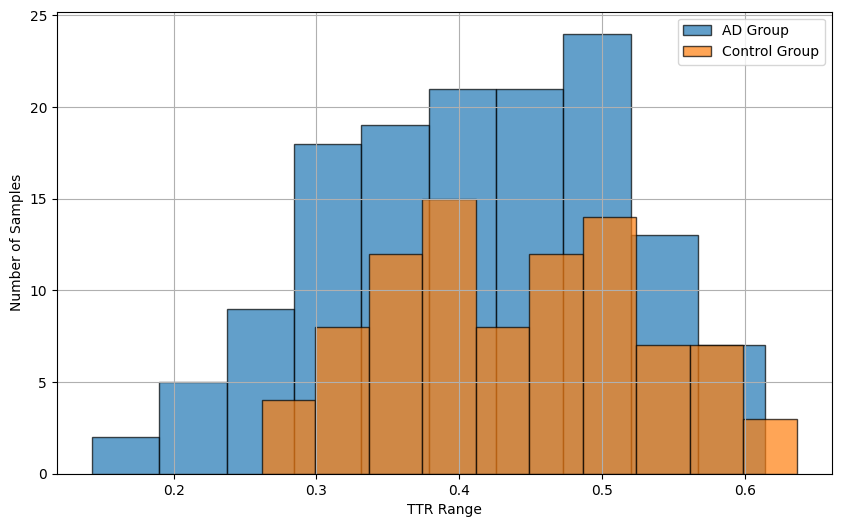

In [1602]:
import matplotlib.pyplot as plt
ad_ddf = df[df['basedx'] == '1']
#ad_ddf = ad_ddf[abs(df['z_score']) <= 2.5]
control_ddf = df[df['basedx'] == '8']


plt.figure(figsize=(10, 6))


plt.hist(ad_ddf['TTR'], bins=10, edgecolor='black', alpha=0.7, label='AD Group')


plt.hist(control_ddf['TTR'], bins=10, edgecolor='black', alpha=0.7, label='Control Group')


plt.xlabel('TTR Range')
plt.ylabel('Number of Samples')
#plt.title('Type Token Ratio Comparison')
plt.grid(True)

plt.legend()
plt.show()


# Age and education matching

In [1603]:
df['Age'] = df['Age'].astype(int)
ad = df[df['basedx'] == '1']['Age']
hc = df[df['basedx'] == '8']['Age']


huh = rp(ad, hc, equal_variances=False)
huh

C:\Users\kaiso\AppData\Roaming\Python\Python310\site-packages\researchpy\ttest.py:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)


(   Variable      N       Mean        SD        SE  95% Conf.   Interval
 0       Age  139.0  72.129496  8.360392  0.709119  70.727353  73.531640
 1       Age   90.0  66.222222  8.154103  0.859518  64.514379  67.930066
 2  combined  229.0  69.807860  8.753332  0.578436  68.668096  70.947625,
         Satterthwaite t-test   results
 0  Difference (Age - Age) =     5.9073
 1      Degrees of freedom =   193.5571
 2                       t =     5.3014
 3   Two side test p value =     0.0000
 4  Difference < 0 p value =     1.0000
 5  Difference > 0 p value =     0.0000
 6               Cohen's d =     0.7134
 7               Hedge's g =     0.7111
 8          Glass's delta1 =     0.7066
 9        Point-Biserial r =     0.3561)

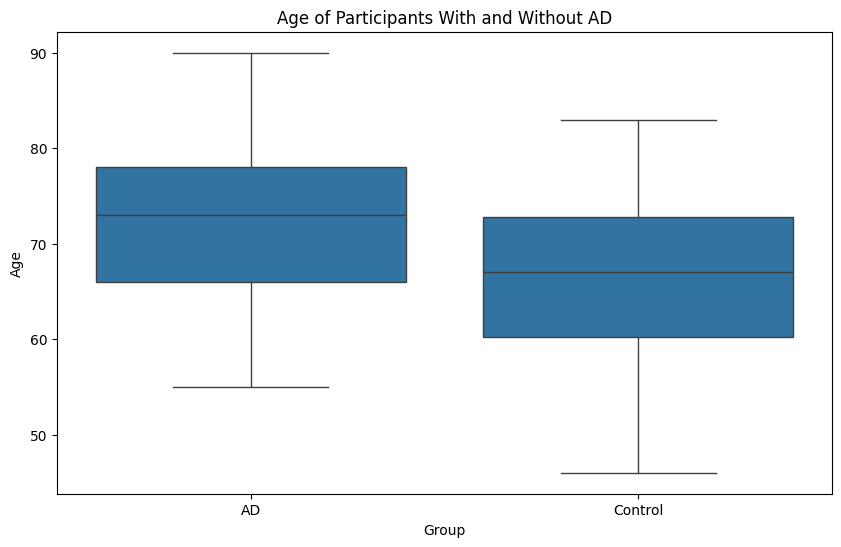

In [1604]:
plt.figure(figsize=(10, 6))  


sns.boxplot(x='basedx', y='Age', data=df, showfliers=True)


plt.xlabel('Group')
plt.ylabel('Age')
plt.title('Age of Participants With and Without AD')


plt.xticks([0, 1], ['AD', 'Control'])
plt.show()

In [1605]:
ad = df[df['basedx'] == '1']['educ']
hc = df[df['basedx'] == '8']['educ']



t_statistic, p_value = ttest_ind(ad, hc, nan_policy='omit')


print(f'\nT-statistic: {t_statistic}')
print(f'P-value: {p_value}')


if p_value < 0.05:
    print('The difference between the groups is statistically significant.')
else:
    print('There is no significant difference between the groups.')


T-statistic: -6.211385446149865
P-value: 2.4794338207816204e-09
The difference between the groups is statistically significant.


In [1606]:
correlation, p_value = pearsonr(df['TTR'], df['educ'])

print("Correlation between TTR and educ for all rows:", correlation)
print("P-value:", p_value)

Correlation between TTR and educ for all rows: 0.1495563267917949
P-value: 0.0236012761932485


In [1607]:
correlation, p_value = pearsonr(df['TTR'], df['Age'])

print("Correlation between TTR and educ for all rows:", correlation)
print("P-value:", p_value)

Correlation between TTR and educ for all rows: -0.18123385764639086
P-value: 0.005952783782753148


In [1608]:
ad = df[df['basedx'] == '1']['educ']
hc = df[df['basedx'] == '8']['educ']


huh = rp(ad, hc, equal_variances=False)
huh

C:\Users\kaiso\AppData\Roaming\Python\Python310\site-packages\researchpy\ttest.py:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)


(   Variable      N       Mean        SD        SE  95% Conf.   Interval
 0      educ  139.0  11.942446  2.693981  0.228500  11.490631  12.394261
 1      educ   90.0  14.122222  2.430276  0.256174  13.613211  14.631234
 2  combined  229.0  12.799127  2.799405  0.184990  12.434618  13.163635,
           Satterthwaite t-test   results
 0  Difference (educ - educ) =    -2.1798
 1        Degrees of freedom =   203.7700
 2                         t =    -6.3500
 3     Two side test p value =     0.0000
 4    Difference < 0 p value =     0.0000
 5    Difference > 0 p value =     1.0000
 6                 Cohen's d =    -0.8404
 7                 Hedge's g =    -0.8376
 8            Glass's delta1 =    -0.8091
 9          Point-Biserial r =    -0.4064)

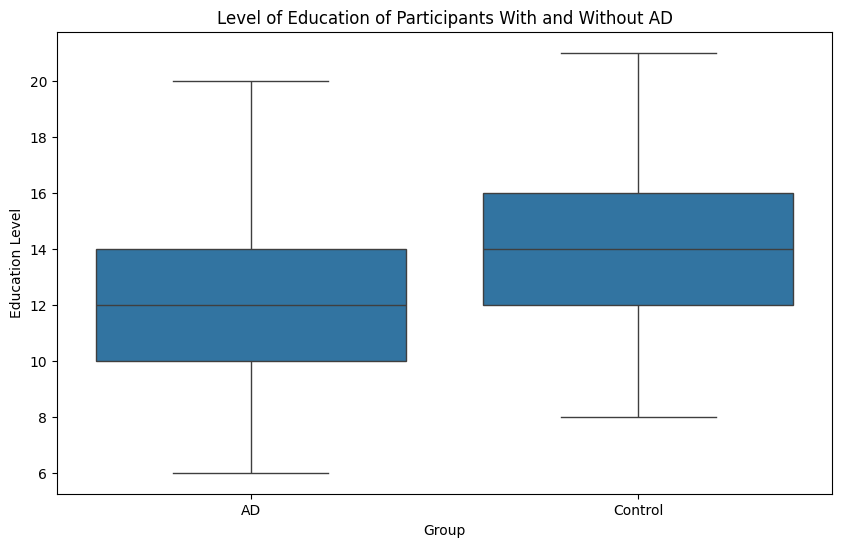

In [1609]:
plt.figure(figsize=(10, 6))  


sns.boxplot(x='basedx', y='educ', data=df, showfliers=True)


plt.xlabel('Group')
plt.ylabel('Education Level')
plt.title('Level of Education of Participants With and Without AD')
plt.xticks([0, 1], ['AD', 'Control'])

plt.show()


In [1610]:
classes = df['basedx'].unique()

for class_label in classes:
    class_data = df.loc[df['basedx'] == class_label, 'TTR']
    
    
    statistic, p_value = shapiro(class_data)
    
    
    print(f"Class: {class_label}")
    print(f"Shapiro-Wilk Test Statistic: {statistic:.4f}")
    print(f"P-value: {p_value:.4f}")

Class: 1
Shapiro-Wilk Test Statistic: 0.9852
P-value: 0.1412
Class: 8
Shapiro-Wilk Test Statistic: 0.9836
P-value: 0.3177


In [1611]:
ad = df[df['basedx'] == '1']['TTR']
hc = df[df['basedx'] == '8']['TTR']



t_statistic, p_value = ttest_ind(ad, hc, nan_policy='omit')


print(f'\nT-statistic: {t_statistic}')
print(f'P-value: {p_value}')

if p_value < 0.05:
    print('The difference between the groups is statistically significant.')
else:
    print('There is no significant difference between the groups.')


T-statistic: -2.187241998174634
P-value: 0.02974594889072528
The difference between the groups is statistically significant.


In [1612]:
ad = df[df['basedx'] == '1']['TTR']
hc = df[df['basedx'] == '8']['TTR']


huh = rp(ad, hc, equal_variances=False)
huh

C:\Users\kaiso\AppData\Roaming\Python\Python310\site-packages\researchpy\ttest.py:38: FutureWarning: The series.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  groups = group1.append(group2, ignore_index= True)


(   Variable      N      Mean        SD        SE  95% Conf.  Interval
 0       TTR  139.0  0.410456  0.103622  0.008789   0.393077  0.427835
 1       TTR   90.0  0.439497  0.088962  0.009377   0.420865  0.458130
 2  combined  229.0  0.421870  0.098947  0.006539   0.408986  0.434754,
         Satterthwaite t-test   results
 0  Difference (TTR - TTR) =    -0.0290
 1      Degrees of freedom =   209.6883
 2                       t =    -2.2596
 3   Two side test p value =     0.0249
 4  Difference < 0 p value =     0.0124
 5  Difference > 0 p value =     0.9876
 6               Cohen's d =    -0.2959
 7               Hedge's g =    -0.2949
 8          Glass's delta1 =    -0.2803
 9        Point-Biserial r =    -0.1542)

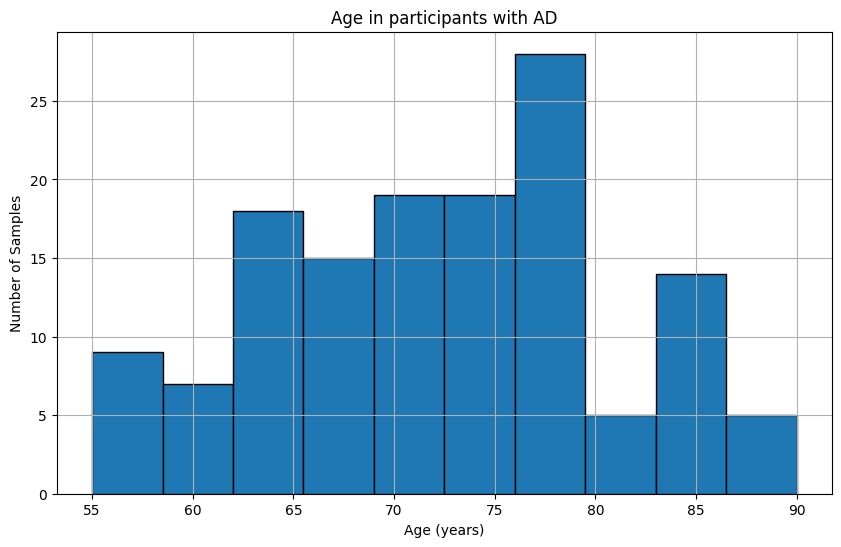

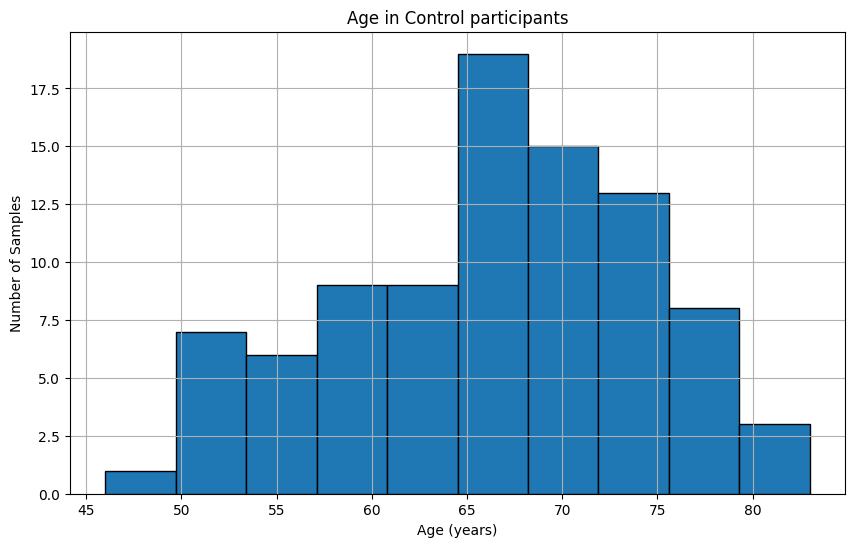

In [1613]:
ad_ddf = df[df['basedx'] == '1']
plt.figure(figsize=(10, 6))
n, bins, _ = plt.hist(ad_ddf['Age'], edgecolor='black', bins = 10) 
plt.xlabel('Age (years)')
plt.ylabel('Number of Samples')
plt.title('Age in participants with AD')
plt.grid(True)



control_ddf = df[df['basedx'] == '8']
plt.figure(figsize=(10, 6))
n, bins, _ = plt.hist(control_ddf['Age'],edgecolor='black', bins=10)  
plt.xlabel('Age (years)')
plt.ylabel('Number of Samples')
plt.title('Age in Control participants')
plt.grid(True)

plt.show()

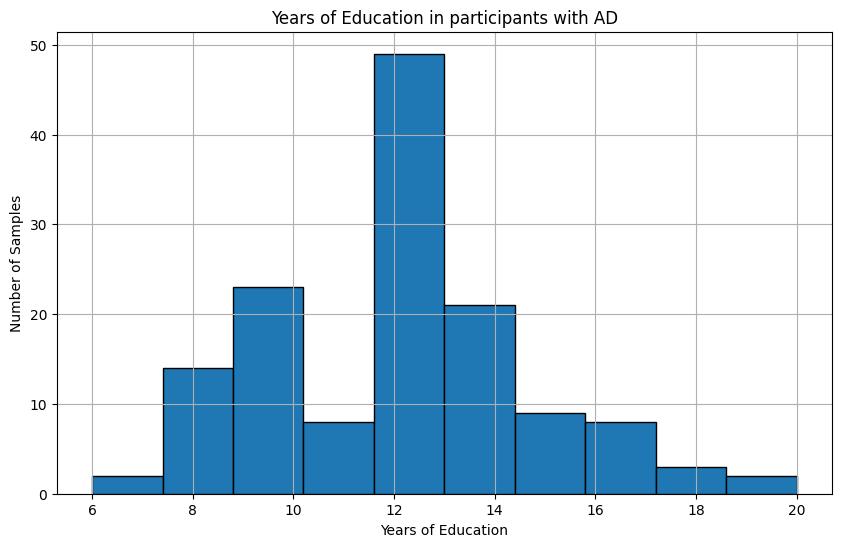

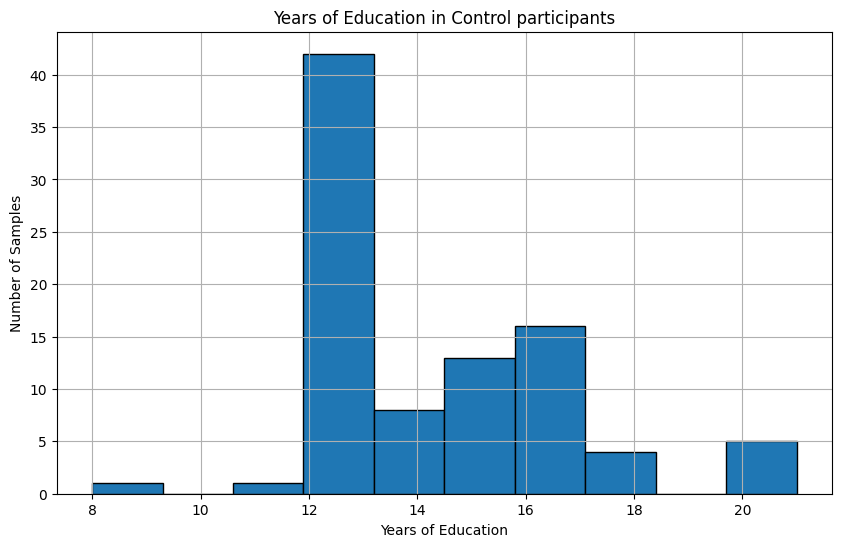

In [1614]:
ad_ddf = df[df['basedx'] == '1']
plt.figure(figsize=(10, 6))
n, bins, _ = plt.hist(ad_ddf['educ'], edgecolor='black', bins=10)  
plt.xlabel('Years of Education')
plt.ylabel('Number of Samples')
plt.title('Years of Education in participants with AD')
plt.grid(True)


control_ddf = df[df['basedx'] == '8']
plt.figure(figsize=(10, 6))
n, bins, _ = plt.hist(control_ddf['educ'],edgecolor='black', bins=10)  
plt.xlabel('Years of Education')
plt.ylabel('Number of Samples')
plt.title('Years of Education in Control participants')
plt.grid(True)

plt.show()

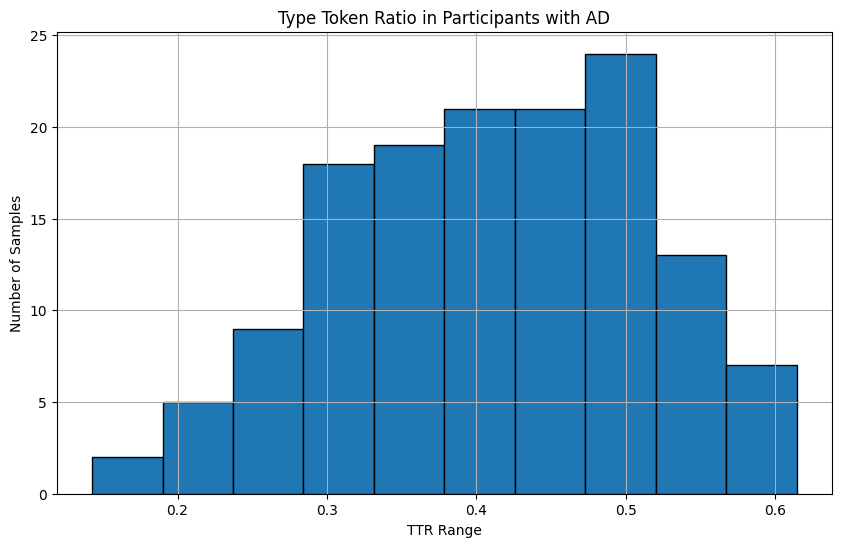

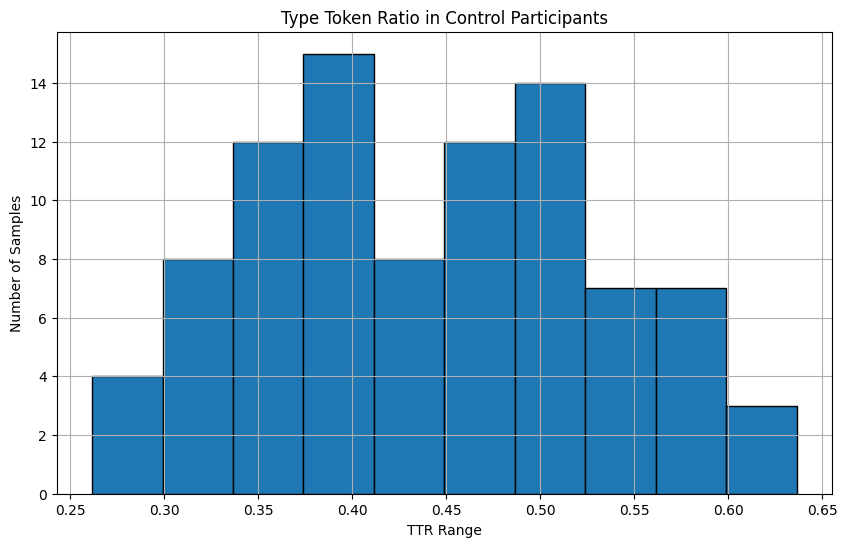

In [1615]:
ad_ddf = df[df['basedx'] == '1']
plt.figure(figsize=(10, 6))
n, bins, _ = plt.hist(ad_ddf['TTR'], edgecolor='black', bins=10)
plt.xlabel('TTR Range')
plt.ylabel('Number of Samples')
plt.title('Type Token Ratio in Participants with AD')
plt.grid(True)


control_ddf = df[df['basedx'] == '8']
plt.figure(figsize=(10, 6))
n, bins, _ = plt.hist(control_ddf['TTR'],edgecolor='black')  
plt.xlabel('TTR Range')
plt.ylabel('Number of Samples')
plt.title('Type Token Ratio in Control Participants')
plt.grid(True)

plt.show()


C:\Users\kaiso\AppData\Local\Temp\ipykernel_1844\722833870.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='basedx', y='TTR', data=df, palette='coolwarm')


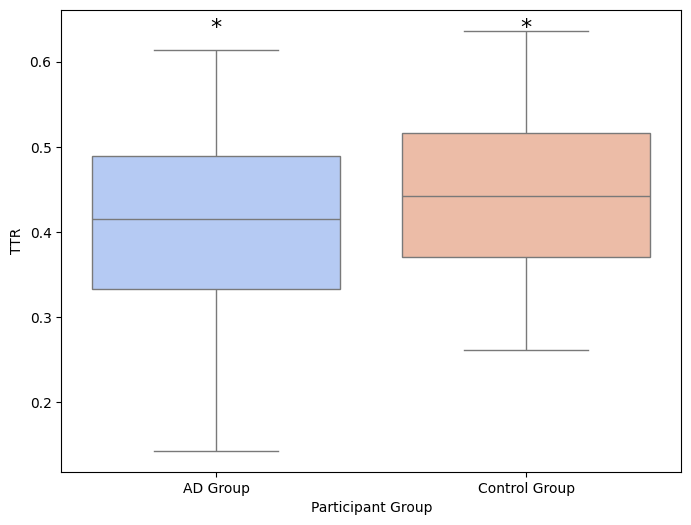

In [1616]:
plt.figure(figsize=(8, 6))
sns.boxplot(x='basedx', y='TTR', data=df, palette='coolwarm')

#plt.title('TTR Distribution for Individuals With and Without AD')
plt.xlabel('Participant Group')
plt.ylabel('TTR')
plt.xticks([0, 1], ['AD Group', 'Control Group'])
p_value = 0.04 

if p_value < 0.05:
    ylim = plt.gca().get_ylim() 
    offset = 0.06 * (ylim[1] - ylim[0]) 
    plt.text(0, ylim[1] - offset, '*', ha='center', va='bottom', fontsize=16) 
    plt.text(1, ylim[1] - offset, '*', ha='center', va='bottom', fontsize=16)

C:\Users\kaiso\AppData\Local\Temp\ipykernel_1844\1871411990.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  bar_plot = sns.barplot(x='basedx', y='mean_TTR', data=summary, palette='coolwarm', ci=None, width=0.4)
C:\Users\kaiso\AppData\Local\Temp\ipykernel_1844\1871411990.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bar_plot = sns.barplot(x='basedx', y='mean_TTR', data=summary, palette='coolwarm', ci=None, width=0.4)


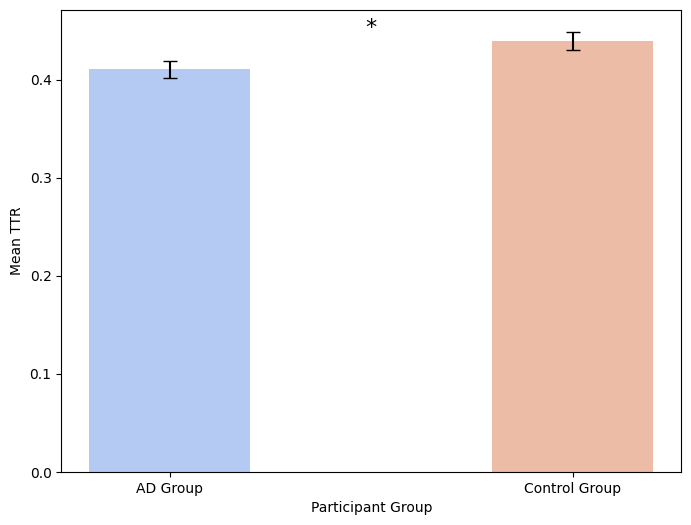

In [1624]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

# Sample DataFrame (replace this with your actual DataFrame)
# df = pd.DataFrame({
#     'basedx': ['AD', 'Control', 'AD', 'Control', ...],
#     'TTR': [5.6, 4.8, 5.2, 4.6, ...]
# })

# Calculate mean and standard error for each group
summary = df.groupby('basedx').agg(
    mean_TTR=('TTR', 'mean'),
    sem_TTR=('TTR', lambda x: np.std(x, ddof=1) / np.sqrt(len(x)))
).reset_index()

# Create the bar plot with narrower bars
plt.figure(figsize=(8, 6))
bar_plot = sns.barplot(x='basedx', y='mean_TTR', data=summary, palette='coolwarm', ci=None, width=0.4)

# Add standard error bars
for index, row in summary.iterrows():
    bar_plot.errorbar(
        x=index, 
        y=row['mean_TTR'], 
        yerr=row['sem_TTR'], 
        fmt='none', 
        capsize=5, 
        color='black'
    )

# Customize plot
plt.xlabel('Participant Group')
plt.ylabel('Mean TTR')
plt.xticks([0, 1], ['AD Group', 'Control Group'])

# Optionally, add a single significance marker in the center
p_value = 0.04
if p_value < 0.05:
    ylim = plt.gca().get_ylim()
    offset = 0.06 * (ylim[1] - ylim[0])
    center_x = (0 + 1) / 2  # Center position between bars
    plt.text(center_x, ylim[1] - offset, '*', ha='center', va='bottom', fontsize=16)

#plt.title('Mean TTR Distribution for Individuals With and Without AD')
plt.show()
